In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import iris
import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

### Define variables and set up environment

In [2]:
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from PDF_plotting_functions import *
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_geometry_functions import *

# Define ensemble member numbers
ems = ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '15']
# Define time period
timeperiod = '1980_2001'

### Choose the spatial datafiles needed

In [3]:
# Create region with Leeds at the centre
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:27700'})
# Create otuline of Leeds itself
leeds_gdf = create_leeds_outline({'init' :'epsg:27700'})

################################################################
### Load in model times, and define which times are within the period which overlaps between model and observations (1990-01-01 00:00:00 and 2000-11-30 23:00:00 )

This is tricky to do as the model date uses a 360 day calendar, with each month having 30 days.  
Consequently, February has 30 days and these dates cannot be recognised by the Datetime function and so it is not possible to trim the data using datetime dates.  
Instead, find the index positions of the dates which are within this time period and assign these a value of '0' in the array  
This array is then stacked on top of itself 1221 times (this is how many cells there are in the leeds-at-centre array).  
This creates an array of the same length as the leeds-at-centre.npy array which contains the precip values.  
These two arrays can then be joined as a dataframe, and all those rows with a '0' in the date column are then deleted to leave only the precip values within the overlapping time period 

In [9]:
model_times_2_2km_npy = np.load(f"ProcessedData/TimeSeries/UKCP18_hourly/2.2km/{timeperiod}/leeds-at-centre/timestamps.npy", allow_pickle=True)
model_times_2_2km_regridded_npy = np.load(f"ProcessedData/TimeSeries/UKCP18_hourly/2.2km_regridded_12km/{timeperiod}/timestamps.npy", allow_pickle=True)
model_times_12km_npy = np.load(f"ProcessedData/TimeSeries/UKCP18_hourly/12km/{timeperiod}/timestamps.npy", allow_pickle=True)

#################################################################
### Loop through ensemble members and load in data for whole of leeds and trim to contain only data from the overlapping time period, and the results do dictionaries
################################################################

In [10]:
# # Create a dictionary to store results
leeds_data_dict = {}
leeds_data_dict_overlapping = {}

In [ ]:
# print(len(data_2_2km_npy))
# print(len(model_times_2_2km_npy)* 1221)

# print(len(data_12km_npy))
# print(len(model_times_12km_npy)*36)

# print(len(data_2_2km_reridded_npy))
# print(len(model_times_2_2km_regridded_npy)*36)

In [11]:
test_date =  datetime.datetime(1990, 1, 1, 0, 0)

In [ ]:
## Do I need to do an end data as well? Or is this just to trim obs? 
### '2000-11-30 23:00:00'

In [15]:
# Loop through ensemble members
for resolution in ['2.2km', '12km', '2.2km_regridded_12km']:
    print(resolution)
    
    for em in ems:
        print(em)
        data_2_2km_npy = np.load(f"ProcessedData/TimeSeries/UKCP18_hourly/2.2km/{timeperiod}/leeds-at-centre/{em}/leeds-at-centre_jja.npy")
        data_12km_npy = np.load(f"ProcessedData/TimeSeries/UKCP18_hourly/12km/{timeperiod}/{em}/leeds-at-centre_jja.npy")
        data_2_2km_reridded_npy = np.load(f"ProcessedData/TimeSeries/UKCP18_hourly/2.2km_regridded_12km/{timeperiod}/{em}/leeds-at-centre_jja.npy")

        # Repeat this 1221 times to be the same length as the precip data for whole of Leeds
        # This is to do with the number of cells (so for 12km and 2.2km_regridded_12km it is 36)
        if resolution == '2.2km':
            leeds_data = pd.concat([pd.DataFrame({'times': model_times_2_2km_npy})]* 1221)
            leeds_data['Precipitation (mm/hr)'] = data_2_2km_npy
        elif resolution == '2.2km_regridded_12km':
            leeds_data = pd.concat([pd.DataFrame({'times': model_times_2_2km_regridded_npy})]* 36)
            leeds_data['Precipitation (mm/hr)'] = data_2_2km_reridded_npy
        elif resolution == '12km':
            leeds_data = pd.concat([pd.DataFrame({'times': model_times_12km_npy})]* 36)
            leeds_data['Precipitation (mm/hr)'] = data_12km_npy
        
        # Add to dictionary
        leeds_data_dict['EM{}_{}'.format(em, resolution)] = leeds_data

        # Keep only data from overlapping times
        leeds_data_overlapping = leeds_data.loc[(leeds_data['times'] > test_date)]

        # Add data to dictionary
        leeds_data_dict_overlapping['EM{}_{}'.format(em, resolution)] = leeds_data_overlapping

        # delete variables to save memory
        del leeds_data, leeds_data_overlapping

2.2km
01
04
05
06
07
08
09
10
11
12
13
15
12km
01
04
05
06
07
08
09
10
11
12
13
15
2.2km_regridded_12km
01
04
05
06
07
08
09
10
11
12
13
15


### Add dictionary keys containing data for all ensemble members, and delete data from individual ensemble members

In [16]:
# Create a dataframe containing the data from across all ensemble members
for dict in [leeds_data_dict, leeds_data_dict_overlapping]:
    for resolution in ['2.2km', '12km', '2.2km_regridded_12km']:
        frames = [dict['EM01_{}'.format(resolution)], dict['EM04_{}'.format(resolution)], dict['EM05_{}'.format(resolution)], dict['EM06_{}'.format(resolution)],
                  dict['EM07_{}'.format(resolution)], dict['EM08_{}'.format(resolution)], dict['EM09_{}'.format(resolution)], dict['EM10_{}'.format(resolution)]
                  , dict['EM11_{}'.format(resolution)], dict['EM12_{}'.format(resolution)], dict['EM13_{}'.format(resolution)], dict['EM15_{}'.format(resolution)]]

        # Add the concat of all these frames to the dictionary
        dict['Model {}'.format(resolution)] = pd.concat(frames)

        # Delete the individual ensemble member dataframes
        keys_to_remove =("EM01_{}".format(resolution), "EM04_{}".format(resolution), "EM05_{}".format(resolution), "EM06_{}".format(resolution), "EM07_{}".format(resolution), "EM08_{}".format(resolution),
                     "EM09_{}".format(resolution), "EM10_{}".format(resolution), "EM11_{}".format(resolution), "EM12_{}".format(resolution), "EM13_{}".format(resolution), "EM15_{}".format(resolution))
        for key in keys_to_remove:
            if key in dict:
                del dict[key]

################################################################
################################################################
### Add both native and regridded observations data to dictionary
################################################################
################################################################

In [18]:
precip =np.load("ProcessedData/TimeSeries/CEH-GEAR/1km/leeds-at-centre_jja.npy", allow_pickle=True)
times = np.load("ProcessedData/TimeSeries/CEH-GEAR/1km/timestamps.npy", allow_pickle=True)

Obs_1km = pd.concat([pd.DataFrame({'times': times})]* 6059)
Obs_1km['Precipitation (mm/hr)'] = precip
leeds_data_dict['Observations_1km']= Obs_1km

In [20]:
precip =np.load("ProcessedData/TimeSeries/CEH-GEAR/2.2km/NearestNeighbour/leeds-at-centre_jja.npy", allow_pickle=True)
times = np.load("ProcessedData/TimeSeries/CEH-GEAR/2.2km/NearestNeighbour/timestamps.npy", allow_pickle=True)

Obs_2_2km = pd.concat([pd.DataFrame({'times': times})]* 1221)
Obs_2_2km['Precipitation (mm/hr)'] = precip
leeds_data_dict['Observations Regridded_2.2km']= Obs_2_2km

In [ ]:
# precip =np.load("ProcessedData/TimeSeries/CEH-GEAR/12km/NearestNeighbour/leeds-at-centre_jja.npy", allow_pickle=True)
# times = np.load("ProcessedData/TimeSeries/CEH-GEAR/12km/timestamps.npy", allow_pickle=True)

# Obs_12km = pd.concat([pd.DataFrame({'times': times})]* 36)
# Obs_12km['Precipitation (mm/hr)'] = precip
# leeds_data_dict['Observations Regridded_12km']= Obs_12km

In [21]:
####### Cut to overlapping period
leeds_data_dict_overlapping['Observations'] =  leeds_data_dict['Observations_1km'][(leeds_data_dict['Observations_1km']['times'] >= '1990-01-01 00:00:00')
                                                & (leeds_data_dict['Observations_1km']['times']<= '2000-11-30 23:00:00')]
# leeds_data_dict_overlapping['Observations Regridded_12km'] = leeds_data_dict['Observations Regridded_12km'][(leeds_data_dict['Observations Regridded_12km']['times'] >= '1990-01-01 00:00:00')
#                                                 & (leeds_data_dict['Observations Regridded_12km']['times'] <= '2000-11-30 23:00:00 ')]
leeds_data_dict_overlapping['Observations Regridded_2.2km'] =  leeds_data_dict['Observations Regridded_2.2km'][(leeds_data_dict['Observations Regridded_2.2km']['times'] >= '1990-01-01 00:00:00')
                                                & (leeds_data_dict['Observations Regridded_2.2km']['times'] <= '2000-11-30 23:00:00 ')]

##############################################################################
##############################################################################
# Plotting
##############################################################################
##############################################################################

In [22]:
x_axis = 'linear'
y_axis = 'log'
bin_nos = 60 #(10 gives 12, 30 gives 29, 45 gives 41 bins)
xlim = 250
bins_if_log_spaced= bin_nos

### All resolutions
#############################################################

In [ ]:
# leeds_data_dict_overlapping['Model 2.2km'].to_csv(f"ProcessedData/TimeSeries/UKCP18/2.2km/Baseline/AllEms_jja.csv")
# leeds_data_dict_overlapping['Model 12km'].to_csv(f"ProcessedData/TimeSeries/UKCP18/12km/Baseline/AllEms_jja.csv")
# leeds_data_dict_overlapping['Model 2.2km_regridded_12km'].to_csv(f"ProcessedData/TimeSeries/UKCP18/2.2km_regridded_12km/Baseline/AllEms_jja.csv")

In [23]:
def log_discrete_histogram_lesslegend(ax, results_dict, cols_dict, wet_values, small_values_only, bin_nos, precip_variable, patches, del_zeroes,
                                      xlim, x_axis_scaling = 'linear', y_axis_scaling = 'log'):
    
    # Create bin edges based on data in all of the dataframes, i.e. use the same bin edges for all dataframes
    min_value = find_min_max_dict_values(results_dict, precip_variable)[0]
    max_value = find_min_max_dict_values(results_dict, precip_variable)[1]
    
    # Maybe min value shoudl be set at 0.05 to make the spacings at the right place
    min_value = 0.05
    discretisation=0.2
    bins_if_log_spaced = bin_nos
    
    # Find edges of bins 
    bin_edges_planned =log_discrete_bins(min_value,max_value,bins_if_log_spaced,discretisation)
    #print ("Based on " + str(bins_if_log_spaced) + " log spaced bins, " + str(len(bin_edges)) + " bins created with " + str(min_value) + str (max_value))
    print(bin_edges_planned)
    # dataframe to store numbers in each bin
    numbers_in_each_bin = pd.DataFrame()
    
    
    for key, df in results_dict.items():
        #print(np.nanmin(df['Precipitation (mm/hr)']))
        if wet_values == True:
            df = df[df['Precipitation (mm/hr)']>0.1]
        if small_values_only == True:
            df = df[df['Precipitation (mm/hr)']<1.5]
        #print(np.nanmin(df['Precipitation (mm/hr)']))
        #print(key)
        # Define the colour to use for this entry
        # Create a patch for this colour to be used in creating the legend
        # And add to list of patches for use in legend
        
        # Find the density in each biin  
        freqs, bin_edges = np.histogram(df[precip_variable], bins= bin_edges_planned, density=True)
        # Find the numbers of precipitation measurements in each bin  
        freqs_numbers, bin_edges = np.histogram(df[precip_variable], bins= bin_edges_planned, density=False)
        
        n_bins = str(len(bin_edges))
        
        # Find the centre point of each bin for plotting
        bin_centres =  0.5*(bin_edges[1:] + bin_edges[:-1])    

        if len(numbers_in_each_bin) ==0:
            numbers_in_each_bin['BinCentres'] = bin_centres
        numbers_in_each_bin[key] = freqs_numbers
        
        # Delete those with a value of 0
        if del_zeroes == True:
            indexes = np.where(freqs == 0)[0]
            #freqs = np.delete(freqs, indexes)
            #bin_centres= np.delete(bin_centres,indexes) 
            for i in range(0, len(freqs)):
                if i in indexes:
                    freqs[i] = np.nan

        # Draw the plot
        ax.scatter(bin_centres, freqs ,linewidth = 1,s=3, color = cols_dict[key])
        ax.plot(bin_centres, freqs ,linewidth = 1, color = cols_dict[key])

    ax.legend(handles=patches)
    ax.set_xlabel(precip_variable)
    ax.set_ylabel('Probability density')
    if xlim != False:
        ax.set_xlim(0,xlim)
    #plt.title(n_bins + " bins")
    ax.set_xscale(x_axis_scaling)
    ax.set_yscale(y_axis_scaling)
    #plt.show()
    #formatter = FormatStrFormatter('%.3f')
    #ax.yaxis.set_major_formatter(formatter)
        
    # Remove scientific notation from y-axis
    # for axis in [ax.yaxis]:
    #     formatter = ScalarFormatter()
    #     formatter.set_scientific(False)
    #     ax.yaxis.set_major_formatter(formatter)
    
    return numbers_in_each_bin

dict_keys(['Model 2.2km', 'Model 12km', 'Model 2.2km_regridded_12km', 'Observations_1km', 'Observations Regridded_2.2km']) 
[0.05, 0.25, 0.45, 0.65, 0.8500000000000001, 1.05, 1.25, 1.45, 1.65, 1.8499999999999999, 2.05, 2.25, 2.45, 2.6500000000000004, 2.8500000000000005, 3.2500000000000004, 3.6500000000000004, 4.050000000000001, 4.450000000000001, 5.050000000000001, 5.65, 6.45, 7.25, 8.25, 9.25, 10.45, 11.85, 13.45, 15.25, 17.25, 19.65, 22.45, 25.65, 29.25, 33.25, 37.85, 43.25, 49.25, 56.25, 64.25, 73.45, 83.85000000000001, 95.85000000000001, 109.45000000000002, 125.05000000000001, 142.85000000000002, 163.25000000000003]


KeyError: 'Model 12km'

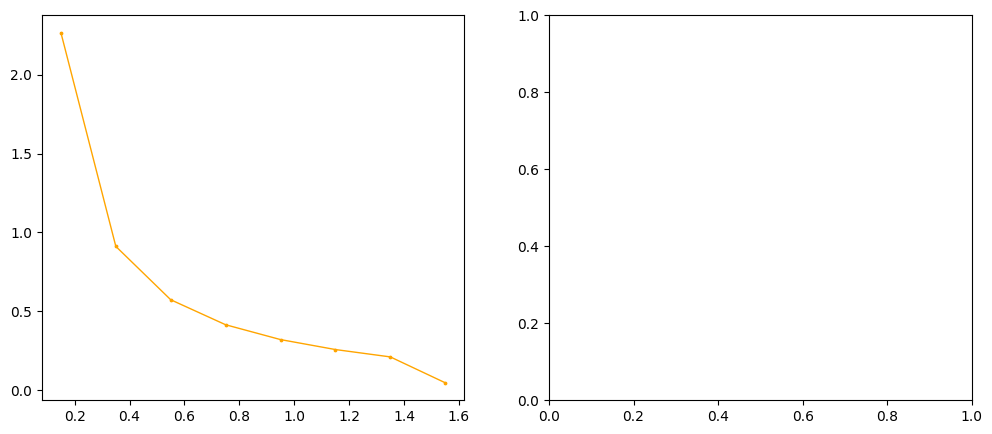

In [24]:
for dict, overlapping_status in zip([leeds_data_dict], [""]):
    print(dict.keys(), overlapping_status)
    cols_dict = {'Observations Regridded_2.2km' : 'black',
                  'Model 2.2km' : 'orange'}
    # Create patches
    patches= []
    for key, val in cols_dict.items():
        patch = mpatches.Patch(color= val, label= key)
        patches.append(patch)
        
    fig, ax = plt.subplots(ncols=2, figsize=(12,5))
    # Create plot
    log_discrete_histogram_lesslegend(ax[0], dict, cols_dict, False, True, bin_nos, "Precipitation (mm/hr)",
                                      patches, True, 3, x_axis, y_axis)#
    log_discrete_histogram_lesslegend(ax[1], dict, cols_dict, False, False, bin_nos, "Precipitation (mm/hr)",
                                      patches, True, 120, x_axis, y_axis)
    #Save
#     plt.savefig("Scripts/UKCP18/PrecipitationPDFs/leeds-at-centre/Figs/RCMvsCPMvsObs/All{}_{}.png".format(overlapping_status, jja_status))

dict_keys(['Model 2.2km', 'Observations Regridded_2.2km']) 


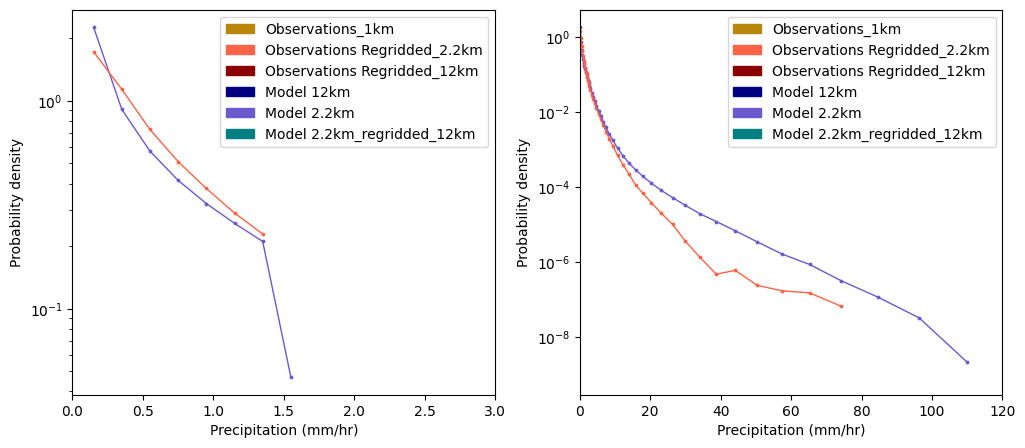

In [116]:
for dict, overlapping_status in zip([leeds_data_dict], [""]):
    print(dict.keys(), overlapping_status)
    cols_dict = {'Observations Regridded_2.2km' : 'black',
                  'Model 2.2km' : 'orange'}
    # Create patches
    patches= []
    for key, val in cols_dict.items():
        patch = mpatches.Patch(color= val, label= key)
        patches.append(patch)
        
    fig, ax = plt.subplots(ncols=2, figsize=(12,5))
    # Create plot
    log_discrete_histogram_lesslegend(ax[0], dict, cols_dict, False, True, bin_nos, "Precipitation (mm/hr)",
                                      patches, True, 3, x_axis, y_axis)#
    log_discrete_histogram_lesslegend(ax[1], dict, cols_dict, False, False, bin_nos, "Precipitation (mm/hr)",
                                      patches, True, 120, x_axis, y_axis)
    #Save
#     plt.savefig("Scripts/UKCP18/PrecipitationPDFs/leeds-at-centre/Figs/RCMvsCPMvsObs/All{}_{}.png".format(overlapping_status, jja_status))

In [130]:
# for dict, overlapping_status in zip([leeds_data_dict, leeds_data_dict_overlapping], ["","_Overlapping"]):
#     print(dict.keys(), overlapping_status)
#     cols_dict = {'Observations' : 'darkgoldenrod',
#                   'Observations Regridded_2.2km' : 'tomato',
#                   'Observations Regridded_12km' : 'darkred',
#                   'Model 12km' : 'navy',
#                   'Model 2.2km' : 'slateblue',
#                   'Model 2.2km_regridded_12km': 'teal'}
#     # Create patches
#     patches= []
#     for key, val in cols_dict.items():
#         patch = mpatches.Patch(color= val, label= key)
#         patches.append(patch)
        
#     fig, ax = plt.subplots(ncols=2)
#     # Create plot
#     log_discrete_histogram_lesslegend(ax[0], dict, cols_dict, True, bin_nos, "Precipitation (mm/hr)",
#                                       patches, True, xlim, x_axis, y_axis)#
#     log_discrete_histogram_lesslegend(ax[1], dict, cols_dict, False, bin_nos, "Precipitation (mm/hr)",
#                                       patches, True, xlim, x_axis, y_axis)
#     #Save
# #     plt.savefig("Scripts/UKCP18/PrecipitationPDFs/leeds-at-centre/Figs/RCMvsCPMvsObs/All{}_{}.png".format(overlapping_status, jja_status))